## This notebook is for Sentiment Analysis on Offensive Language Identification (OLID) Dataset using a Transformer model and LSTM.

Here some links from where the inspiration was taken to complete this assignment:
1. https://www.kaggle.com/code/derrelldsouza/imdb-sentiment-analysis-eda-ml-lstm-bert/notebook

2. https://huggingface.co/docs/transformers/model_doc/bert#transformers.BertForSequenceClassification



### Importing some Basic Libraries and setting up Google Drive and respective directories for specific tasks.

In [ ]:
import pandas as pd
import numpy as np
import os
import shutil

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In the next code block will make our new working directories in our google drive and also will upload the dataset files for later use.
The dataset files inclue:
*   Train File
*   Test File
*   Valid File



In [ ]:
# Saving on Google Drive
GOOGLE_DRIVE_PATH_AFTER_MYDRIVE = os.path.join('./CE807/Assignment2/')
GOOGLE_DRIVE_PATH = os.path.join('gdrive','MyDrive', GOOGLE_DRIVE_PATH_AFTER_MYDRIVE)

# Main file path
if not os.path.exists(GOOGLE_DRIVE_PATH):
  os.makedirs(GOOGLE_DRIVE_PATH)

train=pd.read_csv("/content/train.csv")
test=pd.read_csv("/content/test.csv")
valid=pd.read_csv("/content/valid.csv")

train_path=os.path.join(GOOGLE_DRIVE_PATH, 'train.csv')
test_path=os.path.join(GOOGLE_DRIVE_PATH, 'test.csv')
valid_path=os.path.join(GOOGLE_DRIVE_PATH, 'valid.csv')

train.to_csv(train_path,index=False)
test.to_csv(test_path,index=False)
valid.to_csv(valid_path,index=False)

# Let also make model directories for later use
models=['1','2']
data_sizes=['25','50','75','100']

for model in models:
  for data_size in data_sizes:
    path=os.path.join(GOOGLE_DRIVE_PATH,'models',model,data_size)
    print(path)
    if not os.path.exists(path):
      os.makedirs(path)

gdrive/MyDrive/./CE807/Assignment2/10/models/1/25
gdrive/MyDrive/./CE807/Assignment2/10/models/1/50
gdrive/MyDrive/./CE807/Assignment2/10/models/1/75
gdrive/MyDrive/./CE807/Assignment2/10/models/1/100
gdrive/MyDrive/./CE807/Assignment2/10/models/2/25
gdrive/MyDrive/./CE807/Assignment2/10/models/2/50
gdrive/MyDrive/./CE807/Assignment2/10/models/2/75
gdrive/MyDrive/./CE807/Assignment2/10/models/2/100


## We will be using two well known models which are:

1.   LSTM Based Classifier
2.   Transformer Based BERT Classifier.




 LSTM CLASSIFIER: The LSTM Neural Network artitecture is suited for data which is sequential in nature. That is why it is good for natural language tasks. The model will designed using keras and tensorflow atchitecture.

BERT Classifier: BERT is bidirectional transfomer and it can be fine-tuned for downstream nlp task. For our purpose I will be using BertForSequenceClassification model with original weights taken from bert-base-uncased and then finetune them. The model will be imported from huggingface transformer libraries.

## Training of the selected Classifiers

Importing the Libraries

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 80.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 57.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 22.6 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense,Input, Embedding,LSTM,Dropout,Conv1D, MaxPooling1D, GlobalMaxPooling1D,Dropout,Bidirectional,Flatten,BatchNormalization
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model

import seaborn as sns
import matplotlib.pyplot as plt

import re
import pickle

import torch
from transformers import BertTokenizerFast
from transformers import BertForSequenceClassification
from transformers import Trainer,TrainingArguments

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay


Analyzing the Data

In [ ]:
data_train = pd.read_csv(train_path)
data_test = pd.read_csv(test_path)
data_valid = pd.read_csv(valid_path)

In [ ]:
print(data_train.head())
print(data_test.head())
data_valid.head()

      id                                              tweet label
0  42884  @USER I’m done with you as well. An INTENTIONA...   NOT
1  92152  I now have over 6k followers.  Only 94k to go ...   NOT
2  65475  @USER Tom was bought! He is more interested in...   NOT
3  22144  @USER @USER Even her brother thinks she is a m...   OFF
4  81048  @USER @USER @USER @USER @USER I can understand...   OFF
      id                                              tweet label
0  15923  #WhoIsQ #WheresTheServer #DumpNike #DECLASFISA...   OFF
1  27014  #ConstitutionDay is revered by Conservatives, ...   NOT
2  30530  #FOXNews #NRA #MAGA #POTUS #TRUMP #2ndAmendmen...   NOT
3  13876  #Watching #Boomer getting the news that she is...   NOT
4  60133  #NoPasaran: Unity demo to oppose the far-right...   OFF


,id,tweet,label
0,12476,@USER @USER @USER Trump is declassifying infor...,NOT
1,23242,@USER Ha even with them trying to rig the syst...,NOT
2,97885,@USER @USER @USER Man you really thought this ...,NOT
3,43414,@USER Ms. Clinton - you are a class act. My re...,OFF
4,81403,@USER It’s still here at 753. If someone did t...,NOT


In [ ]:
data_train.shape,data_test.shape,data_valid.shape

((12313, 3), (860, 3), (927, 3))

The Preprocessing and Cleaning steps will be:
1. We will only leave english text in our tweets.
2. Will remove any special characters along with punctuations.
3. Will remove tags(@,# and their suffixes)  and urls, links from our tweets.

In [ ]:
# Funtion for cleaning the tweets
def clean_tweet(data_train):
  data_train['tweet'] = data_train['tweet'].apply(lambda x: x.lower())
  data_train['tweet']= data_train['tweet'].apply(lambda x:re.sub(r'\#[^\s]+','',x))
  data_train['tweet'] = data_train['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
  data_train['tweet'] = data_train['tweet'].apply(lambda x:x.strip())
  data_train['tweet'] = data_train['tweet'].str.replace("user","")
  data_train['tweet'] = data_train['tweet'].str.replace("url","")
  return data_train['tweet']

In [ ]:
data_train['tweet']=clean_tweet(data_train)
data_test['tweet']=clean_tweet(data_test)
data_valid['tweet']=clean_tweet(data_valid)

In [ ]:
for i in range(0,5):
  print(data_train['tweet'][i])

 im done with you as well an intentional 11th hour attack completely based on hearsay and you want an investigation what do you think theyll find other than he said she said feinstein admitted she sat on this and here you are ready to lockstep with the swamp
i now have over 6k followers  only 94k to go to get to my goal
 tom was bought he is more interested in tom than his constituents
  even her brother thinks she is a monster 
     i can understand that and if its someone i know ill debate with them but im not willing to spend that much time trying to change the mind of someone i dont know i tryed that with people and gun control and it just get stupid because they wont try to understand


After Cleaning we will Visualize the Data to help us understand the underlying Features of dataset and its class distribution.
We will primarily do our analysis on only train dataset. As this will give us better understanding of OLID dataset.

Class Distribution

NOT    8221
OFF    4092
Name: label, dtype: int64


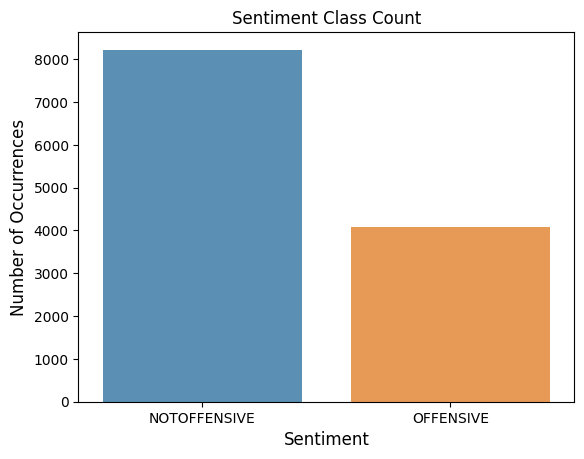

In [ ]:
value_counts=data_train['label'].value_counts()
print(value_counts)
sns.barplot(x=value_counts.index, y=value_counts.values, alpha=0.8)
plt.title('Sentiment Class Count')
plt.ylabel('Number of Occurrences', fontsize=12)
plt.xlabel("Sentiment",fontsize=12)
plt.xticks(ticks = np.arange(2),labels = ['NOTOFFENSIVE','OFFENSIVE'])
plt.show()

 We have class imbalance in our dataset as notoffensive tweets are greater in number than offensive ones

Now lets look into the text sequence length of tweets this will help us to determine tokenizer optmized tokenizer max size later. 

<ipython-input-49-40675c786500>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word, ax=ax1,color='green')
<ipython-input-49-40675c786500>:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(word,ax=ax2,color='red')


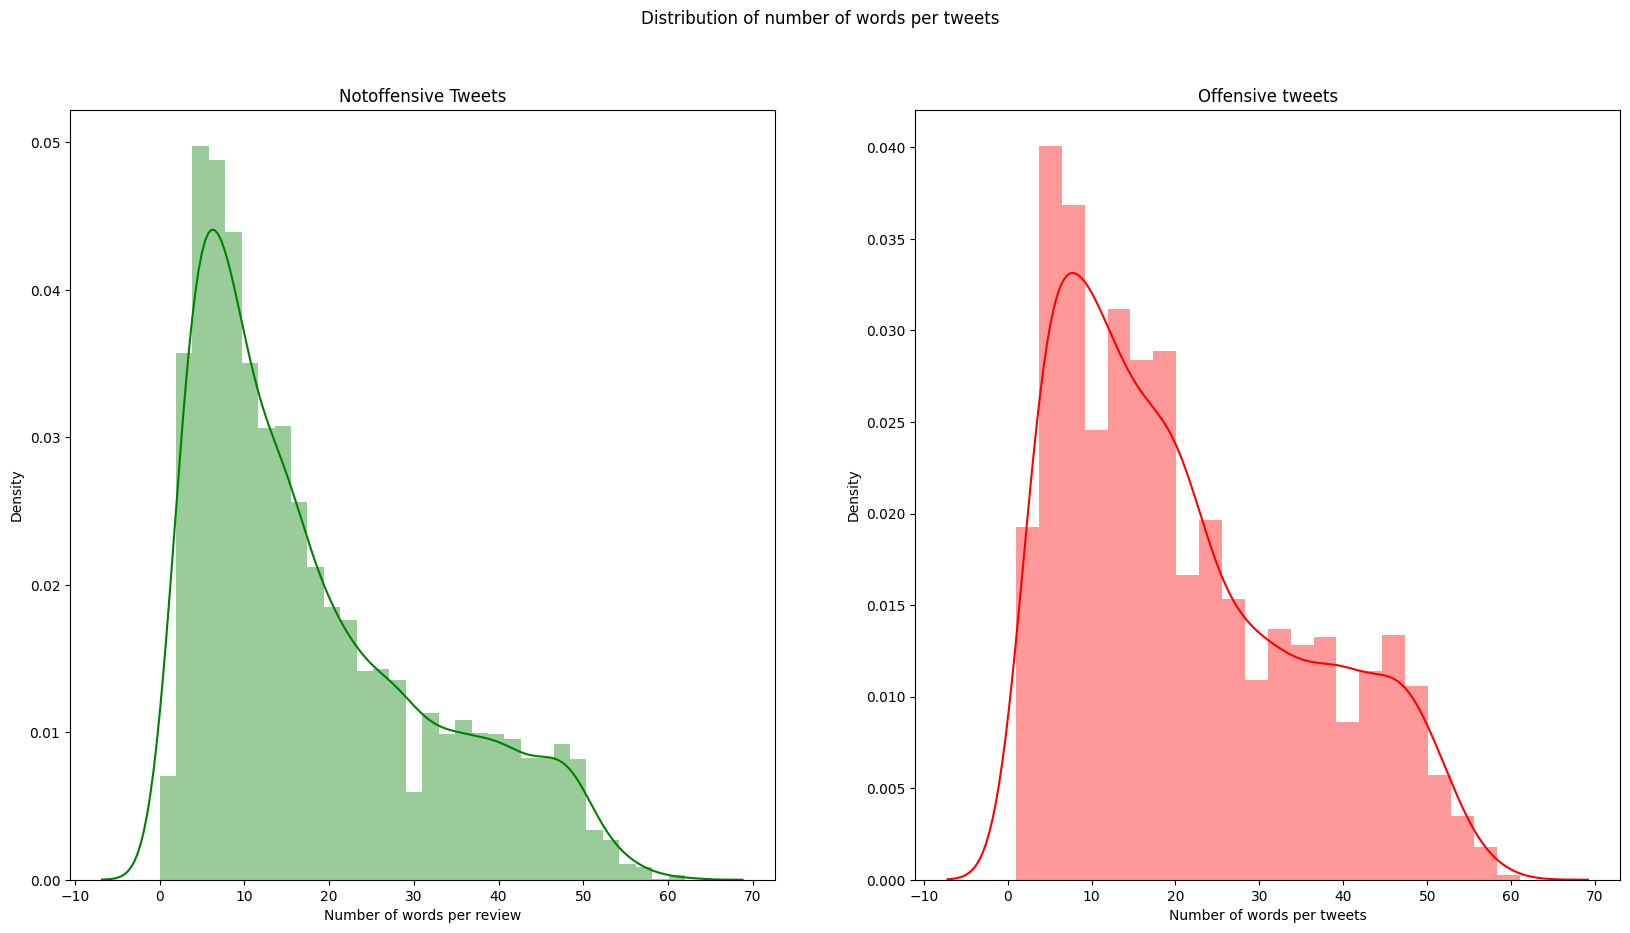

In [ ]:
off_tweets = data_train[data_train['label']=='OFF']
notoff_tweets = data_train[data_train['label']=='NOT']

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(20,10))
word = notoff_tweets['tweet'].apply(lambda x:len(x.split()))
sns.distplot(word, ax=ax1,color='green')
ax1.set_title('Notoffensive Tweets')
ax1.set_xlabel('Number of words per review')
word = off_tweets['tweet'].apply(lambda x:len(x.split()))
sns.distplot(word,ax=ax2,color='red')
ax2.set_title('Offensive tweets')
ax2.set_xlabel('Number of words per tweets')
fig.suptitle('Distribution of number of words per tweets')
plt.show()



---


Now lets dive in to the machine learning part 
For this task we will use our complete training dataset then use the train_test split for varying sizes.

We will train our LSTM based classifier first

In [ ]:
# Defining function to encode our target label

def label_encoding(df):
  df['label']=df['label'].replace(['OFF','NOT'],[0,1]).astype(int)
  return df['label']

In [ ]:
# Setting up model accuracy,loss plot both for training and validation dataset

def plotLearningCurve(history,epochs):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  plt.show()

In [ ]:
data_train['label']=label_encoding(data_train)
data_test['label']=label_encoding(data_test)
data_valid['label']=label_encoding(data_valid)

Xtrain, ytrain = data_train['tweet'], data_train['label']
Xtest, ytest = data_test['tweet'], data_test['label']

Xvalid, yvalid = data_valid['tweet'], data_valid['label']

Now we will train our tokenizer for LSTM model on our train dataset vocabulary.
The tokenizer is taken from keras text preprocessing module.
This will enocode our tweet in numerical representation

In [ ]:
MAX_VOCAB_SIZE = 15000
tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
tokenizer.fit_on_texts(Xtrain)
word_index = tokenizer.word_index
V = len(word_index)

In [ ]:
seq_train = tokenizer.texts_to_sequences(Xtrain)
seq_test =  tokenizer.texts_to_sequences(Xtest)
seq_valid=tokenizer.texts_to_sequences(Xvalid)

In [ ]:
# The tokenized sequences:
seq_train[0],seq_train[1]

([78,
  242,
  21,
  7,
  32,
  117,
  57,
  5867,
  2950,
  1617,
  420,
  580,
  839,
  18,
  8259,
  6,
  7,
  86,
  57,
  897,
  30,
  43,
  7,
  73,
  1367,
  335,
  116,
  90,
  11,
  128,
  15,
  128,
  840,
  2655,
  15,
  1813,
  18,
  17,
  6,
  138,
  7,
  9,
  782,
  4,
  5868,
  21,
  2,
  928],
 [10, 74, 22, 113, 8260, 898, 83, 8261, 4, 88, 4, 62, 4, 55, 1307])



---
---


They have varying shape according to the size of tweet size.
We have to make them of equal size so we will pad the sequences.

In [ ]:
#choice of maximum length of sequences
seq_len_list = [len(i) for i in seq_train + seq_test]

#if we take the direct maximum then
max_len=max(seq_len_list)
print('Maximum length of sequence in the list: {}'.format(max_len))

# when setting the maximum length of sequence, variability around the average is used.
max_seq_len = np.mean(seq_len_list) + 2 * np.std(seq_len_list)
max_seq_len = int(max_seq_len)
print('Maximum length of the sequence when considering data only two standard deviations from average: {}'.format(max_seq_len))

Maximum length of sequence in the list: 62
Maximum length of the sequence when considering data only two standard deviations from average: 47


In [ ]:
# Increase the sequence length little bit to be on safe side
max_seq_len=55

In [ ]:
# Creating Padded sequences
pad_train=pad_sequences(seq_train,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_test=pad_sequences(seq_test,truncating = 'post', padding = 'pre',maxlen=max_seq_len)
pad_valid=pad_sequences(seq_valid,truncating = 'post', padding = 'pre',maxlen=max_seq_len)

Xtrain=pad_train
Xtest=pad_test
Xvalid=pad_valid

Initializing the Model

In [ ]:
def lstm_model(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.3)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.3)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.5)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0005),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32)
                  #callbacks = callbacks
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

In [ ]:
D = 64 #embedding dims
epochs = 5
r,model,n_epochs = lstm_model(Xtrain,Xvalid,ytrain,yvalid,V,D,max_seq_len,epochs)

----Building the model----
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 55)]              0         
                                                                 
 embedding_1 (Embedding)     (None, 55, 64)            1173760   
                                                                 
 batch_normalization_1 (Batc  (None, 55, 64)           256       
 hNormalization)                                                 
                                                                 
 dropout_3 (Dropout)         (None, 55, 64)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 51, 32)            10272     
                                                                 
 dropout_4 (Dropout)         (None, 51, 32)            0         
                                

In [ ]:
type(model)

keras.engine.functional.Functional

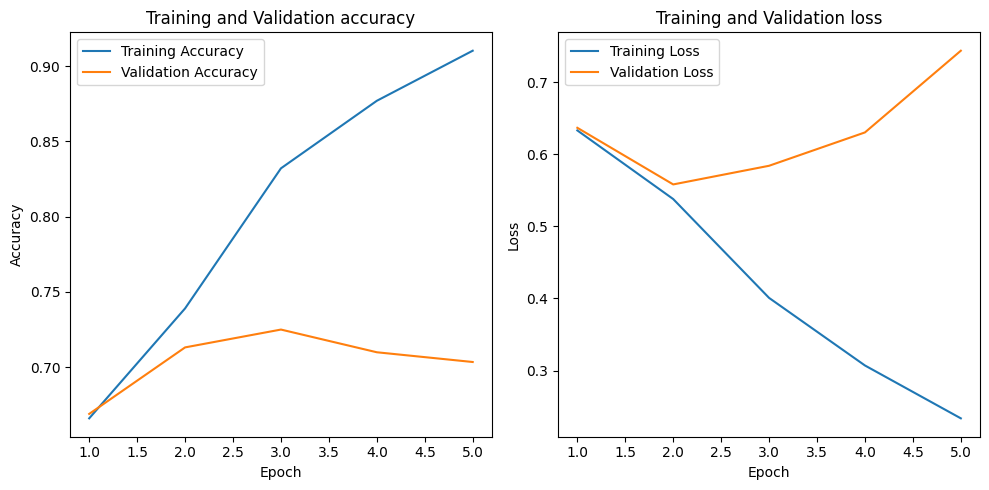

In [ ]:
# Now we will call the function that we declare above
plotLearningCurve(r,n_epochs)

Now will test our model on test dataset


In [ ]:
print("Evaluate Model Performance on Test set")
result = model.evaluate(pad_test,ytest)
print(dict(zip(model.metrics_names, result)))

Evaluate Model Performance on Test set
27/27 [==============================] - 0s 6ms/step - loss: 0.6706 - accuracy: 0.7337
{'loss': 0.6705777645111084, 'accuracy': 0.7337209582328796}


 We will now plot the confusion matrix see the model performance on each class.

27/27 [==============================] - 1s 5ms/step


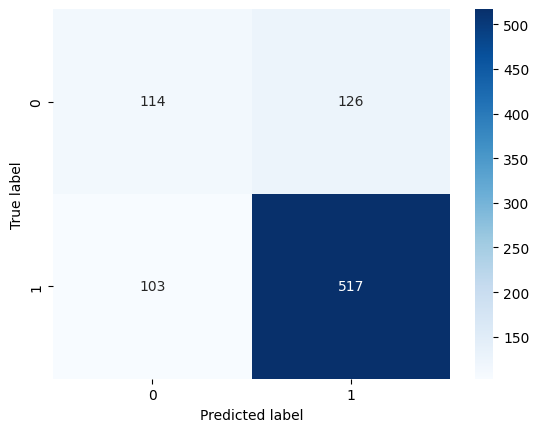

In [ ]:
#Generate predictions for the test dataset
ypred = model.predict(pad_test)
ypred = ypred>0.5
#Get the confusion matrix
cf_matrix = confusion_matrix(ytest, ypred)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()



---



---


**The confusion matrix show that we predicted label 1 quite better than label 0. This is due to the class imbalance issue. We have already observe this class imbalance above**

---



Now will jump to Bert-base classifier Model

We will first instiate our tokenizer. We will be using bert tokenizer from transfomer library which is already trained on english corpus.

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

In [ ]:
def for_step2_data(df):
  return df['tweet'],df['label']

In [ ]:
Xtrain, ytrain = for_step2_data(data_train)
Xtest, ytest = for_step2_data(data_test)
Xval, yval = for_step2_data(data_valid)


In [ ]:
# Just verifying the data
Xtrain[0],Xtrain.shape

(' im done with you as well an intentional 11th hour attack completely based on hearsay and you want an investigation what do you think theyll find other than he said she said feinstein admitted she sat on this and here you are ready to lockstep with the swamp',
 (12313,))

In [ ]:
# Now we tokenize our tweet using bert tokenizer

In [ ]:
x_train_inputs = tokenizer(Xtrain.tolist(),padding="max_length",truncation=True,max_length=128)
x_test_inputs=tokenizer(Xtest.tolist(),padding="max_length",truncation=True,max_length=128)
val_inputs = tokenizer(Xval.tolist(),padding="max_length",truncation=True,max_length=128)

val_inputs.keys()

dict_keys(['input_ids', 'token_type_ids', 'attention_mask'])

In [ ]:
# Now will convert our dataset into torch data_type

In [ ]:
class td(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings=encodings
    self.labels=labels
  
  def __getitem__(self,idx):
    item = {key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)

train_dset = td(x_train_inputs,ytrain.tolist())
val_dset=td(val_inputs,yval.tolist())

In [ ]:
# Now will declare our Bert Classification Model

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

Lets see how our model prediction on our test data without finetuning it.

In [ ]:
# Defining the Output Function
def output(test):
    input_ids = torch.tensor(test["input_ids"]).to(device)
    attention_mask = torch.tensor(test["attention_mask"]).to(device)
    with torch.no_grad():
        outputs = model(input_ids.unsqueeze(0),attention_mask.unsqueeze(0))
    y = np.argmax(outputs[0].to('cpu').numpy())
    y_prob = torch.nn.functional.softmax(outputs[0],dim=-1)[0][y].to('cpu').numpy()
    return y,y_prob

def output1(input_ids,attention_mask,model):
  input_ids = torch.tensor(input_ids).to(device)
  attention_mask = torch.tensor(attention_mask).to(device)
  with torch.no_grad():
      outputs = model(input_ids.unsqueeze(0),attention_mask.unsqueeze(0))
  y = np.argmax(outputs[0].to('cpu').numpy())
  y_prob = torch.nn.functional.softmax(outputs[0],dim=-1)[0][y].to('cpu').numpy()
  return y,y_prob

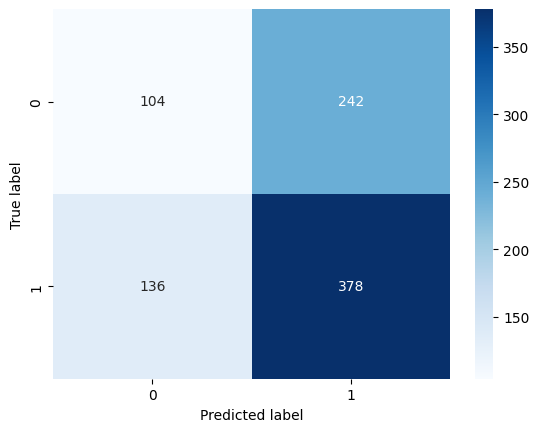

In [ ]:
test_preds=[]
for tok_tweet in range(len(x_test_inputs['input_ids'])) :
  op,p_op = output1(x_test_inputs['input_ids'][tok_tweet],x_test_inputs['attention_mask'][tok_tweet],model)
  test_preds.append(op)

cf_matrix = confusion_matrix(test_preds, ytest)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

Very poor results shown my confusion matrix as expected from the base model



---

Now will begin our training. To use appropriate training measures I will use trainer  and training argument functionality by huggingface to train our transfomer model

In [ ]:
training_args = TrainingArguments(
    output_dir='None',
    num_train_epochs=2,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=250,
    weight_decay=0.01,
    logging_steps=10)

trainer = Trainer(model=model,args=training_args,train_dataset=train_dset,eval_dataset=val_dset)
trainer.train()

/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss
10,0.716000
20,0.694000
30,0.639700
40,0.636200
50,0.640700
60,0.666200
70,0.627400
80,0.595900
90,0.596900
100,0.602600


TrainOutput(global_step=770, training_loss=0.43030692695023176, metrics={'train_runtime': 508.2161, 'train_samples_per_second': 48.456, 'train_steps_per_second': 1.515, 'total_flos': 1619843212323840.0, 'train_loss': 0.43030692695023176, 'epoch': 2.0})

In [ ]:
trainer.state.log_history[-1]

{'train_runtime': 508.2161,
 'train_samples_per_second': 48.456,
 'train_steps_per_second': 1.515,
 'total_flos': 1619843212323840.0,
 'train_loss': 0.43030692695023176,
 'epoch': 2.0,
 'step': 770}

In [ ]:
shutil.rmtree('/content/None')

 Now let see our prediction after finetuning it on our dataset.

In [ ]:
test_preds=[]
for tok_tweet in range(len(x_test_inputs['input_ids'])) :
  op,p_op = output1(x_test_inputs['input_ids'][tok_tweet],x_test_inputs['attention_mask'][tok_tweet],model)
  test_preds.append(op)

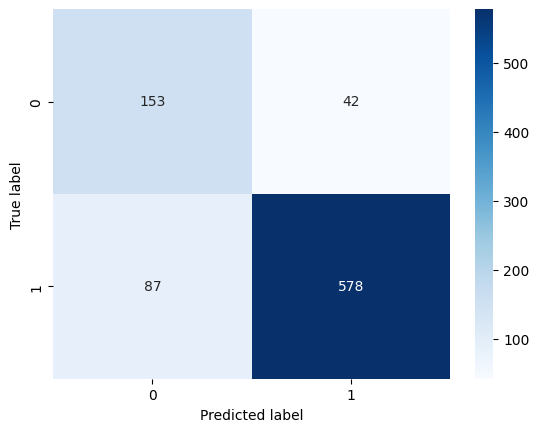

In [ ]:
cf_matrix = confusion_matrix(test_preds, ytest)
sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

The results improve drastically after fine tuning our model.
lets also print the classification report which contain all the necessary metrics to judge our results.

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(test_preds, ytest, target_names=['Offensive','Notoffensive']))

              precision    recall  f1-score   support

   Offensive       0.64      0.78      0.70       195
Notoffensive       0.93      0.87      0.90       665

    accuracy                           0.85       860
   macro avg       0.78      0.83      0.80       860
weighted avg       0.87      0.85      0.86       860



In [ ]:
accuracy_score(test_preds,ytest)

0.85

# Now we will train our models on differnet train sizes of:
1. 25%
2. 50%
3. 75%
4. 100%

Lets first make some desired methods for our models as to prevent repetition in the code.

In [ ]:
def reading_dataset(train_path,test_path,valid_path):
  
  train_file=pd.read_csv(train_path)
  test_file=pd.read_csv(test_path)
  val_file=pd.read_csv(valid_path)

  return train_file,test_file,val_file

def cleaning_and_target_encoding(df):
  df['tweet'] = df['tweet'].apply(lambda x: x.lower())
  df['tweet']= df['tweet'].apply(lambda x:re.sub(r'\#[^\s]+','',x))
  df['tweet'] = df['tweet'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))
  df['tweet'] = df['tweet'].apply(lambda x:x.strip())
  df['tweet'] = df['tweet'].str.replace("user","")
  df['tweet'] = df['tweet'].str.replace("url","")

  df['label']=df['label'].replace(['OFF','NOT'],[0,1]).astype(int)
  return df

In [ ]:
def plot_confusion_matrix(test_preds,ytest,model_dir):
  cf_matrix = confusion_matrix(test_preds, ytest)
  sns.heatmap(cf_matrix,annot = True,fmt ='g', cmap='Blues')
  plt.xlabel('Predicted label')
  plt.ylabel('True label')
  title=model_dir.split("/")[-1]
  plt.title(f"Model For Train Data {title} %")
  plt.show()

To attain different train sizes of dataset I will use train_test_split from sklearn.
To ensure the proportion integerity of the target label I will use the stratify parameter when calling the train_test_split

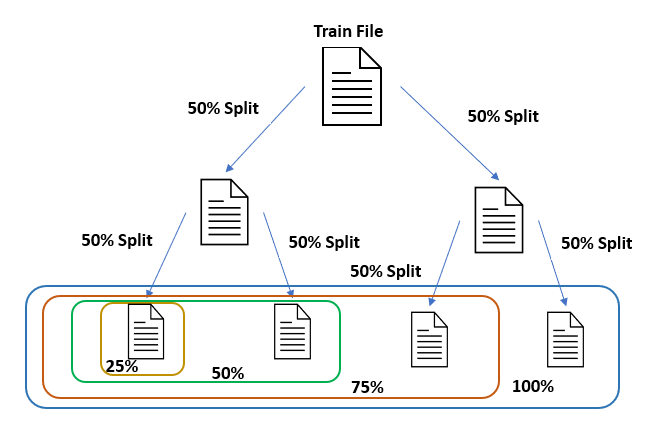

In [ ]:
def split_function(train_file,model_dir):
  X,y=train_file['tweet'],train_file['label']
  x,xt, y,yt= train_test_split(X,y, test_size=0.5, random_state=student_id,stratify=y)
  x1,x2, y1,y2= train_test_split(x,y, test_size=0.5, random_state=student_id,stratify=y)
  x3,x4,y3,y4=train_test_split(xt,yt, test_size=0.5, random_state=student_id,stratify=yt)

  train_25=x1
  train_y25=y1
  
  train_50=pd.concat([x1,x2])
  train_y50=pd.concat([y1,y2])

  train_75=pd.concat([x1,x2,x3])
  train_y75=pd.concat([y1,y2,y3])

  train_100=pd.concat([x1,x2,x3,x4])
  train_y100=pd.concat([y1,y2,y3,y4])

  print("The shape of vary train data are:")
  print(f"25% train_data:{train_25.shape}\n50% train_data:{train_50.shape}\n75% train_data:{train_75.shape}\n100% train_data:{train_100.shape}")

  if model_dir.split("/")[-1]=='25':
    return train_25,train_y25
  if model_dir.split("/")[-1]=='50':
    return train_50,train_y50
  if model_dir.split("/")[-1]=='75':
    return train_75,train_y75
  if model_dir.split("/")[-1]=='100':
    return train_100,train_y100

In [ ]:
# Setting up functions for LSTM's tokenizer 
def meth1_train_tokenizer(Tokenizer,train_data):
  MAX_VOCAB_SIZE = 15000
  tokenizer = Tokenizer(num_words = MAX_VOCAB_SIZE,oov_token="<oov>")
  tokenizer.fit_on_texts(train_data)
  word_index = tokenizer.word_index
  #print(word_index)
  V = len(word_index)

  return tokenizer,V

def meth1_tokenize_seq(tweets,tokenizer):
  seq_tokenized = tokenizer.texts_to_sequences(tweets)
  seq_tokenized_padded=pad_sequences(seq_tokenized,truncating = 'post', padding = 'pre',maxlen=55)
  return seq_tokenized_padded


In [ ]:
def meth1_plotLearningCurve(history,epochs,model_dir):
  epochRange = range(1,epochs+1)
  fig , ax = plt.subplots(1,2,figsize = (10,5))
  
  ax[0].plot(epochRange,history.history['accuracy'],label = 'Training Accuracy')
  ax[0].plot(epochRange,history.history['val_accuracy'],label = 'Validation Accuracy')
  ax[0].set_title('Training and Validation accuracy')
  ax[0].set_xlabel('Epoch')
  ax[0].set_ylabel('Accuracy')
  ax[0].legend()
  ax[1].plot(epochRange,history.history['loss'],label = 'Training Loss')
  ax[1].plot(epochRange,history.history['val_loss'],label = 'Validation Loss')
  ax[1].set_title('Training and Validation loss')
  ax[1].set_xlabel('Epoch')
  ax[1].set_ylabel('Loss')
  ax[1].legend()
  fig.tight_layout()
  title=model_dir.split("/")[-1]
  fig. suptitle(f"Model For Train Data {title} %", fontsize=5)
  plt.show()

# Now defining our model initiliazer and training loop.

def meth1_my_LSTM(Xtrain,Xval,ytrain,yval,V,D,maxlen,epochs,model_dir):

    print("----Building the model----")
    i = Input(shape=(maxlen,))
    x = Embedding(V + 1, D,input_length = maxlen)(i)
    x = BatchNormalization()(x)
    x = Dropout(0.4)(x)
    x = Conv1D(32,5,activation = 'relu')(x)
    x = Dropout(0.4)(x)
    x = MaxPooling1D(2)(x)
    x = Bidirectional(LSTM(128,return_sequences=True))(x)
    x = LSTM(64)(x)
    x = Dropout(0.4)(x)
    x = Dense(1, activation='sigmoid')(x)
    model = Model(i, x)
    model.summary()

    #Training the LSTM
    print("----Training the network----")
    model.compile(optimizer= Adam(0.0004),
              loss='binary_crossentropy',
              metrics=['accuracy'])
    
    checkpoint = ModelCheckpoint(model_dir, 
    verbose=1, 
    monitor='val_loss',
    save_best_only=True, 
    mode='auto'
)  
    r = model.fit(Xtrain,ytrain, 
                  validation_data = (Xval,yval), 
                  epochs = epochs, 
                  verbose = 2,
                  batch_size = 32,
                  callbacks = [checkpoint])
    
    print("Train score:", model.evaluate(Xtrain,ytrain))
    print("Validation score:", model.evaluate(Xval,yval))
    n_epochs = len(r.history['loss'])
    
    return r,model,n_epochs 

Now will defing training method1 which will take train_file,val_file,model_dir as function argument.

model_dir path will be used to save BEST model in specific directory and also will be use to determine the train data size.

In [ ]:
def train_method1(train_file,val_file,model_dir):
  
  x_train,y_train=split_function(train_file,model_dir)
  print(x_train)
  
  print("---------")
  tokenizer,V=meth1_train_tokenizer(Tokenizer,x_train)

  #saving tokenizer
  tokenizer_path=os.path.join(model_dir,'tokenizer.pickle')
  with open(tokenizer_path, 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
  
  print('vocab',V)
  x_train_tokenized_padded=meth1_tokenize_seq(x_train,tokenizer)
  
  val_tweet , val_label=val_file['tweet'],val_file['label']
  val_padded_seq=meth1_tokenize_seq(val_tweet,tokenizer)
  
  #return x_train_tokenized_padded,y_train,val_padded_seq,val_label
  
  D = 64 #embedding dims
  epochs = 4
  r,model,n_epochs = meth1_my_LSTM(x_train_tokenized_padded,val_padded_seq,y_train,val_label,V,D,55,epochs,model_dir)
  print("-------------------------------------------------")
  meth1_plotLearningCurve(r,n_epochs,model_dir)
  print("Saving model to the model directory",model_dir)
  model.save(model_dir)
  #return x_train_tokenized_padded,val_padded_seq  

The test methods is specific to the model and will be used to evaluate predictions for test dataset. It will also print confusion matrix and classification report containinfg F1 , Precsion and Recall score etc.

The best saved model from train method is also loaded from its specific directory.

The final prediction will be saved in specific directory as "output.csv"

In [ ]:
def test_method1(test_file,model_file_dir,output):
  model=keras.models.load_model(model_file_dir)

  tokenizer_path=os.path.join(model_file_dir,'tokenizer.pickle')
  with open(tokenizer_path, 'rb') as handle:
    tokenizer = pickle.load(handle)

  test_tweet , test_label=test_file['tweet'],test_file['label']
  test_pad_seq=meth1_tokenize_seq(test_tweet,tokenizer)

  ypred = model.predict(test_pad_seq)
  ypred = ypred>0.5

  plot_confusion_matrix(ypred , test_label, model_file_dir)

  report=classification_report(ypred, test_label, target_names=['Offensive','Notoffensive'])
  
  print(report)
  report=classification_report(ypred, test_label, target_names=['Offensive','Notoffensive'],output_dict=True)
  
  test_file['out_label']=ypred
  test_file['out_label']=test_file['out_label'].replace([0,1],['OFF','NOT'])
  print("------------")
  print(f"Saving output file to {model_file_dir}")
  output_dir=os.path.join(model_file_dir,output)
  test_file.to_csv(output_dir,index=False)
  return report



In [ ]:
train_file,test_file,val_file=reading_dataset(train_path,test_path,valid_path)

train_file=cleaning_and_target_encoding(train_file)
test_file=cleaning_and_target_encoding(test_file)
val_file=cleaning_and_target_encoding(val_file)
print(train_file.head())

      id                                              tweet  label
0  42884   im done with you as well an intentional 11th ...      1
1  92152  i now have over 6k followers  only 94k to go t...      1
2  65475   tom was bought he is more interested in tom t...      1
3  22144          even her brother thinks she is a monster       0
4  81048       i can understand that and if its someone ...      0


In [ ]:
# Setting up the model directory.
model_dir1_100=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/1/100"
model_dir1_75=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/1/75"
model_dir1_50=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/1/50"
model_dir1_25=f"gdrive/MyDrive/./CE807/Assignment2/{str(student_id)}/models/1/25"

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)
2896      hey   they all cant come to us  come on  we h...
11947     iya risi in my area didnt get the money she i...
8023      keep up the good work you do and ignore the h...
7720     asmr eel sushi salmon sushi eating sounds big ...
2052        divert and defamewe voted him in to get thi...
                               ...                        
5556                                         mark my words
4546     itself specifically targets minorities  the en...
4704     2 examples of the group newsletters we created...
7123       she is correct corbyn and mcdonald would be ...
11459     donald trump in nevada either at that maga ra...
Name: tweet, Length: 12313, dtype: object
---------
vocab 18339
----Building the model----
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape        

385/385 - 64s - loss: 0.6360 - accuracy: 0.6650 - val_loss: 0.6456 - val_accuracy: 0.6677 - 64s/epoch - 165ms/step
Epoch 2/4

Epoch 2: val_loss improved from 0.64558 to 0.57597, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/100


385/385 - 37s - loss: 0.5797 - accuracy: 0.7057 - val_loss: 0.5760 - val_accuracy: 0.7163 - 37s/epoch - 95ms/step
Epoch 3/4

Epoch 3: val_loss improved from 0.57597 to 0.57383, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/100


385/385 - 24s - loss: 0.4643 - accuracy: 0.7891 - val_loss: 0.5738 - val_accuracy: 0.7195 - 24s/epoch - 63ms/step
Epoch 4/4

Epoch 4: val_loss did not improve from 0.57383
385/385 - 7s - loss: 0.3826 - accuracy: 0.8343 - val_loss: 0.5819 - val_accuracy: 0.7282 - 7s/epoch - 18ms/step
385/385 [==============================] - 2s 5ms/step - loss: 0.2690 - accuracy: 0.9064
Train score: [0.26899391412734985, 0.9064403772354126]
29/29 [==============================] - 0s 6ms/step - loss: 0.5819 - accuracy: 0.7282
Validation score: [0.5818649530410767, 0.7281553149223328]
-------------------------------------------------


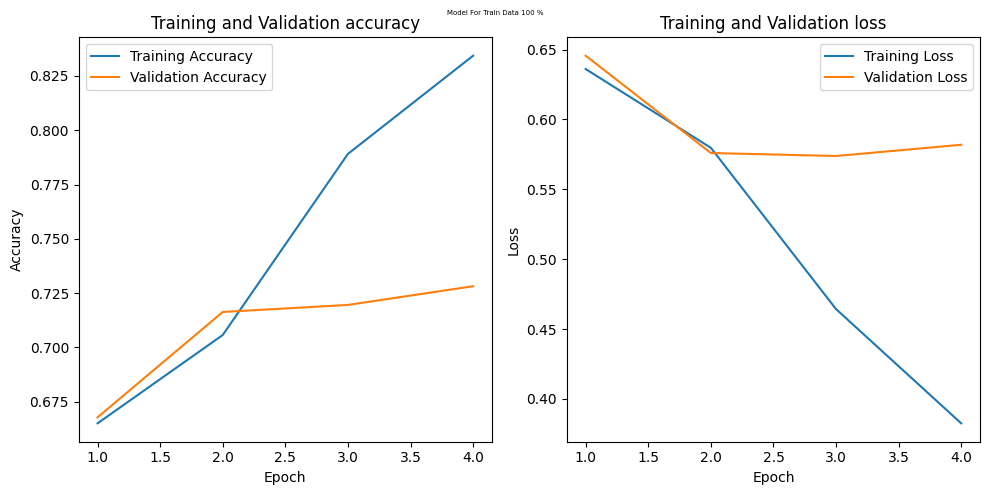

Saving model to the model directory gdrive/MyDrive/./CE807/Assignment2/10/models/1/100


In [ ]:
# Starting training
train_method1(train_file,val_file,model_dir1_100)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)
2896      hey   they all cant come to us  come on  we h...
11947     iya risi in my area didnt get the money she i...
8023      keep up the good work you do and ignore the h...
7720     asmr eel sushi salmon sushi eating sounds big ...
2052        divert and defamewe voted him in to get thi...
                               ...                        
938         because im a little concerned about the q f...
11620     tbh these days i just dont like people in gen...
2015       people like you are the greatest campaign to...
8593               but but but all those gun control laws 
12107    party that wants to deport  that are on  growi...
Name: tweet, Length: 9234, dtype: object
---------
vocab 15543
----Building the model----
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape         

289/289 - 67s - loss: 0.6391 - accuracy: 0.6634 - val_loss: 0.6583 - val_accuracy: 0.6677 - 67s/epoch - 232ms/step
Epoch 2/4

Epoch 2: val_loss improved from 0.65830 to 0.58615, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/75


289/289 - 28s - loss: 0.5900 - accuracy: 0.6988 - val_loss: 0.5861 - val_accuracy: 0.7163 - 28s/epoch - 96ms/step
Epoch 3/4

Epoch 3: val_loss improved from 0.58615 to 0.57769, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/75


289/289 - 26s - loss: 0.4714 - accuracy: 0.7865 - val_loss: 0.5777 - val_accuracy: 0.7217 - 26s/epoch - 89ms/step
Epoch 4/4

Epoch 4: val_loss did not improve from 0.57769
289/289 - 7s - loss: 0.3771 - accuracy: 0.8393 - val_loss: 0.6020 - val_accuracy: 0.7087 - 7s/epoch - 24ms/step
289/289 [==============================] - 2s 6ms/step - loss: 0.2473 - accuracy: 0.9202
Train score: [0.24727286398410797, 0.9201862812042236]
29/29 [==============================] - 0s 5ms/step - loss: 0.6020 - accuracy: 0.7087
Validation score: [0.6019935011863708, 0.708737850189209]
-------------------------------------------------


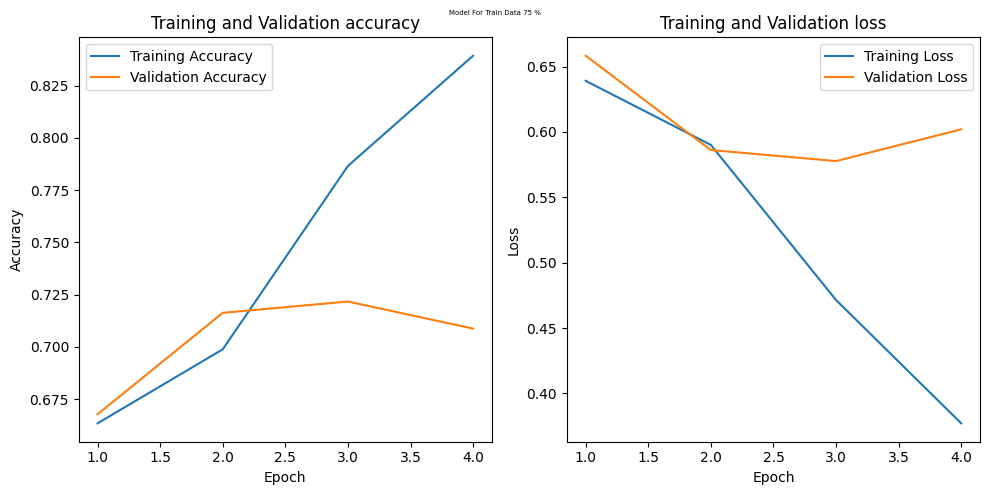

Saving model to the model directory gdrive/MyDrive/./CE807/Assignment2/10/models/1/75


In [ ]:
train_method1(train_file,val_file,model_dir1_75)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)
2896      hey   they all cant come to us  come on  we h...
11947     iya risi in my area didnt get the money she i...
8023      keep up the good work you do and ignore the h...
7720     asmr eel sushi salmon sushi eating sounds big ...
2052        divert and defamewe voted him in to get thi...
                               ...                        
1268             and when logic fails you arent a twitt...
11180    conservatives  theresa_may since my very first...
10774       so have the conservatives accepted the anti...
11713      why isnt the basic issue of survival of the ...
2462      knew it was a lie can see you laughing to you...
Name: tweet, Length: 6156, dtype: object
---------
vocab 12297
----Building the model----
Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape         

193/193 - 57s - loss: 0.6360 - accuracy: 0.6615 - val_loss: 0.6565 - val_accuracy: 0.6677 - 57s/epoch - 296ms/step
Epoch 2/4

Epoch 2: val_loss improved from 0.65653 to 0.62555, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/50


193/193 - 27s - loss: 0.6139 - accuracy: 0.6745 - val_loss: 0.6256 - val_accuracy: 0.6721 - 27s/epoch - 139ms/step
Epoch 3/4

Epoch 3: val_loss improved from 0.62555 to 0.60173, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/50


193/193 - 23s - loss: 0.5217 - accuracy: 0.7542 - val_loss: 0.6017 - val_accuracy: 0.7077 - 23s/epoch - 121ms/step
Epoch 4/4

Epoch 4: val_loss did not improve from 0.60173
193/193 - 6s - loss: 0.3877 - accuracy: 0.8338 - val_loss: 0.6428 - val_accuracy: 0.7023 - 6s/epoch - 30ms/step
193/193 [==============================] - 1s 7ms/step - loss: 0.2426 - accuracy: 0.9269
Train score: [0.24256515502929688, 0.9269005656242371]
29/29 [==============================] - 0s 8ms/step - loss: 0.6428 - accuracy: 0.7023
Validation score: [0.6428061127662659, 0.7022653818130493]
-------------------------------------------------


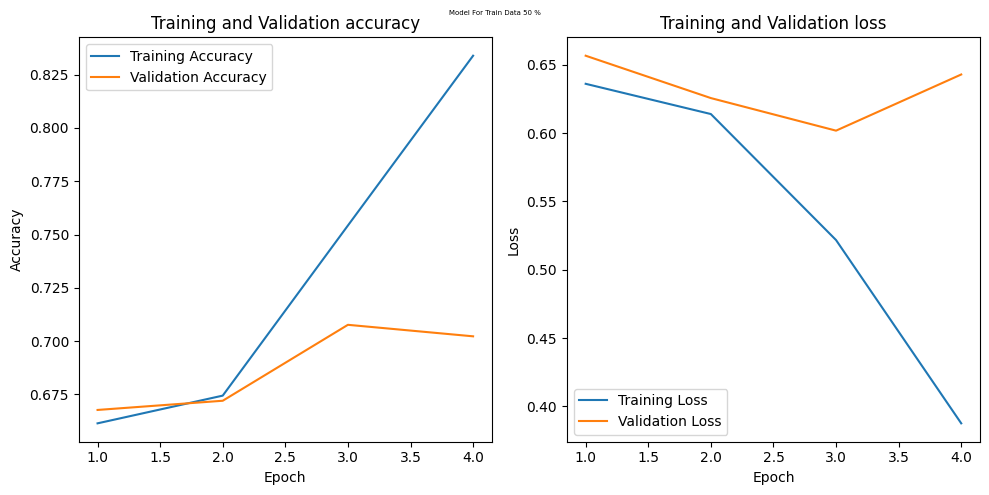

Saving model to the model directory gdrive/MyDrive/./CE807/Assignment2/10/models/1/50


In [ ]:
train_method1(train_file,val_file,model_dir1_50)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)
2896      hey   they all cant come to us  come on  we h...
11947     iya risi in my area didnt get the money she i...
8023      keep up the good work you do and ignore the h...
7720     asmr eel sushi salmon sushi eating sounds big ...
2052        divert and defamewe voted him in to get thi...
                               ...                        
2544       and your fans keep going back and forth betw...
8874       california gun control is direct result of w...
4396      it would make sense for her to be a big chara...
2483       maybe he is making amends before  passes at ...
10404                                      you are funny  
Name: tweet, Length: 3078, dtype: object
---------
vocab 8241
----Building the model----
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape          

97/97 - 50s - loss: 0.6410 - accuracy: 0.6615 - val_loss: 0.6712 - val_accuracy: 0.6677 - 50s/epoch - 516ms/step
Epoch 2/4

Epoch 2: val_loss did not improve from 0.67117
97/97 - 18s - loss: 0.6268 - accuracy: 0.6644 - val_loss: 0.6741 - val_accuracy: 0.6677 - 18s/epoch - 181ms/step
Epoch 3/4

Epoch 3: val_loss improved from 0.67117 to 0.66370, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/25


97/97 - 26s - loss: 0.5973 - accuracy: 0.6884 - val_loss: 0.6637 - val_accuracy: 0.6775 - 26s/epoch - 265ms/step
Epoch 4/4

Epoch 4: val_loss improved from 0.66370 to 0.64175, saving model to gdrive/MyDrive/./CE807/Assignment2/10/models/1/25


97/97 - 23s - loss: 0.4729 - accuracy: 0.7846 - val_loss: 0.6417 - val_accuracy: 0.6602 - 23s/epoch - 236ms/step
97/97 [==============================] - 1s 6ms/step - loss: 0.4985 - accuracy: 0.9045
Train score: [0.4984969198703766, 0.904483437538147]
29/29 [==============================] - 0s 6ms/step - loss: 0.6417 - accuracy: 0.6602
Validation score: [0.6417456865310669, 0.6601941585540771]
-------------------------------------------------


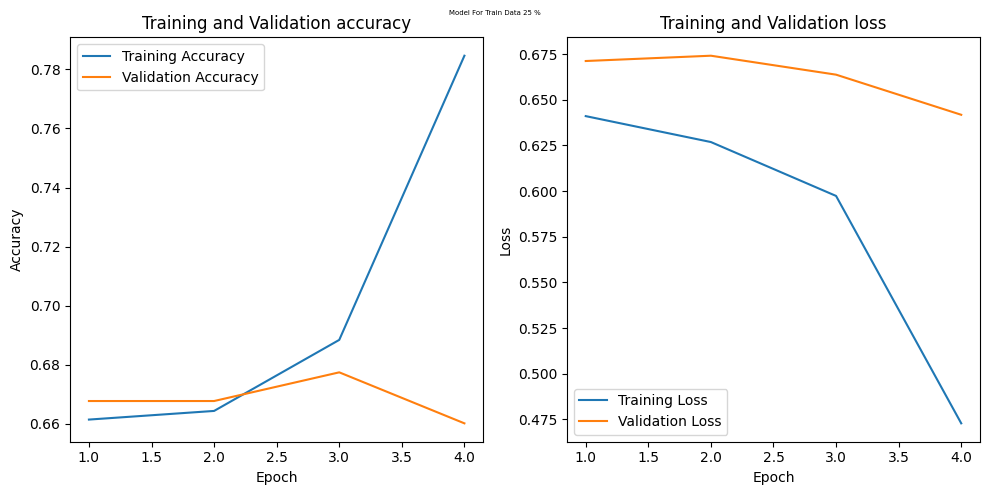

Saving model to the model directory gdrive/MyDrive/./CE807/Assignment2/10/models/1/25


In [ ]:
train_method1(train_file,val_file,model_dir1_25)

27/27 [==============================] - 1s 5ms/step


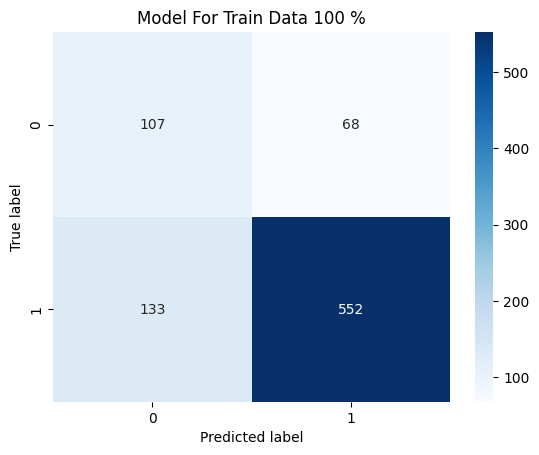

              precision    recall  f1-score   support

   Offensive       0.45      0.61      0.52       175
Notoffensive       0.89      0.81      0.85       685

    accuracy                           0.77       860
   macro avg       0.67      0.71      0.68       860
weighted avg       0.80      0.77      0.78       860

------------
Saving output file to gdrive/MyDrive/./CE807/Assignment2/10/models/1/100


In [ ]:
report_1_100=test_method1(test_file,model_dir1_100,'output_test.csv')

27/27 [==============================] - 1s 6ms/step


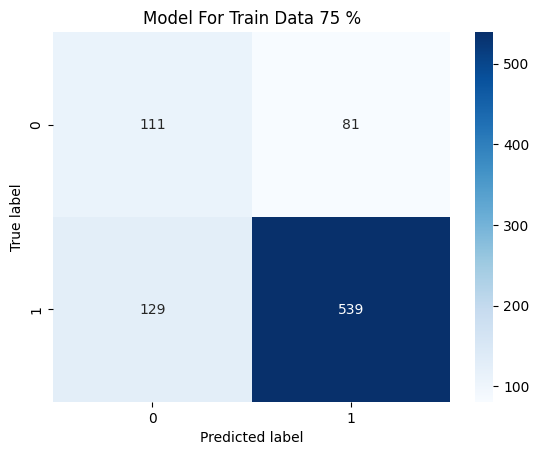

              precision    recall  f1-score   support

   Offensive       0.46      0.58      0.51       192
Notoffensive       0.87      0.81      0.84       668

    accuracy                           0.76       860
   macro avg       0.67      0.69      0.68       860
weighted avg       0.78      0.76      0.76       860

------------
Saving output file to gdrive/MyDrive/./CE807/Assignment2/10/models/1/75


In [ ]:
report_1_75=test_method1(test_file,model_dir1_75,'output_test.csv')

27/27 [==============================] - 1s 5ms/step


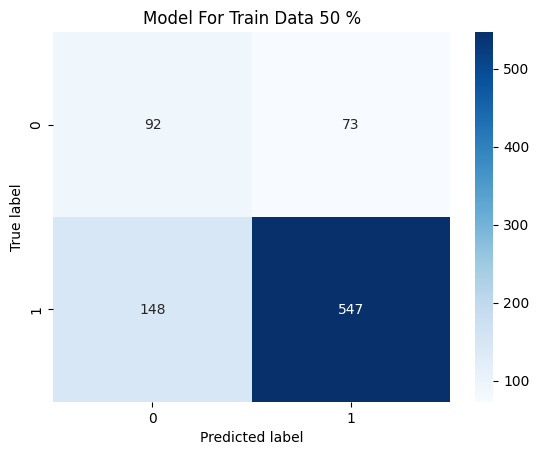

              precision    recall  f1-score   support

   Offensive       0.38      0.56      0.45       165
Notoffensive       0.88      0.79      0.83       695

    accuracy                           0.74       860
   macro avg       0.63      0.67      0.64       860
weighted avg       0.79      0.74      0.76       860

------------
Saving output file to gdrive/MyDrive/./CE807/Assignment2/10/models/1/50


In [ ]:
report_1_50=test_method1(test_file,model_dir1_50,'output_test.csv')

27/27 [==============================] - 2s 6ms/step


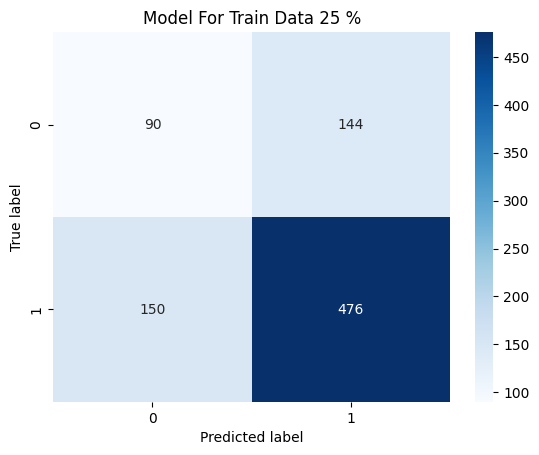

              precision    recall  f1-score   support

   Offensive       0.38      0.38      0.38       234
Notoffensive       0.77      0.76      0.76       626

    accuracy                           0.66       860
   macro avg       0.57      0.57      0.57       860
weighted avg       0.66      0.66      0.66       860

------------
Saving output file to gdrive/MyDrive/./CE807/Assignment2/10/models/1/25


In [ ]:
report_1_25=test_method1(test_file,model_dir1_25,'output_test.csv')

LSTM model performance decline by lowering the train size

# Now will define  workflow for BERT classifier with slight different implemetation.

In [ ]:
class tor_dataset(torch.utils.data.Dataset):
  def __init__(self,encodings,labels):
    self.encodings=encodings
    self.labels=labels
  
  def __getitem__(self,idx):
    item = {key:torch.tensor(val[idx]) for key,val in self.encodings.items()}
    item["labels"] = torch.tensor(self.labels[idx])
    return item
  def __len__(self):
    return len(self.labels)


def method2_tokenize(seq,tokenizer):
  sq_tokenize= tokenizer(seq.tolist(),padding="max_length",truncation=True,max_length=128)
  return sq_tokenize


def train_method2(train_file,val_file,model_dir,bert_tokenizer,model):
  x_train,y_train=split_function(train_file,model_dir)
  val_tweet , val_label=val_file['tweet'],val_file['label']

  x_train_tok=method2_tokenize(x_train,bert_tokenizer)
  val_train_tok=method2_tokenize(val_tweet,bert_tokenizer)

  train_dset = tor_dataset(x_train_tok,y_train.tolist())
  val_dset=tor_dataset(val_train_tok,val_label.tolist())

  # setting up the training arguments now

  training_args = TrainingArguments(
    output_dir='None',
    num_train_epochs=3,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    warmup_steps=250,
    weight_decay=0.01,
    logging_steps=100,
    overwrite_output_dir=True,
    #evaluation_strategy='epoch',
    load_best_model_at_end=True,
    save_strategy= "steps",
    save_total_limit=2,
    evaluation_strategy='steps')

  trainer = Trainer(model=model,args=training_args,train_dataset=train_dset,eval_dataset=val_dset
      )
  trainer.train()
  print("The last training state is:")
  print(trainer.state.log_history[-1])
  print("----\n\n")
  print(f"Saving the best model to directory: {model_dir}")
  model.save_pretrained(model_dir)
  shutil.rmtree('/content/None')

In [ ]:
def method2_pred_funct(input_ids,attention_mask,model):
  input_ids = torch.tensor(input_ids).to(device)
  attention_mask = torch.tensor(attention_mask).to(device)
  with torch.no_grad():
      outputs = model(input_ids.unsqueeze(0),attention_mask.unsqueeze(0))
  y = np.argmax(outputs[0].to('cpu').numpy())
  y_prob = torch.nn.functional.softmax(outputs[0],dim=-1)[0][y].to('cpu').numpy()
  return y,y_prob

def test_method2(test_file,model_file,output,tokenizer):
  
  model=BertForSequenceClassification.from_pretrained(model_file,num_labels=2).to(device)
  test_tweet , test_label=test_file['tweet'],test_file['label']
  
  test_tok=method2_tokenize(test_tweet,bert_tokenizer)
  
  test_preds=[]
  for tok_tweet in range(len(test_tok['input_ids'])) :
    op,p_op = method2_pred_funct(test_tok['input_ids'][tok_tweet],test_tok['attention_mask'][tok_tweet],model)
    test_preds.append(op)
  
  # Printing prediction statistics
  plot_confusion_matrix(test_preds , test_label, model_file)

  report=classification_report(test_preds, test_label, target_names=['Offensive','Notoffensive'])
  print(report)
  report=classification_report(test_preds, test_label, target_names=['Offensive','Notoffensive'],output_dict=True)
  print("The Accuracy Score")

  print(accuracy_score(test_preds,test_label))

  print("")
  test_file['out_label']=test_preds
  test_file['out_label']=test_file['out_label'].replace([0,1],['OFF','NOT'])
  output_dir=os.path.join(model_file,output)
  test_file.to_csv(output_dir,index=False)
  return report

In [ ]:
train_file,test_file,val_file=reading_dataset(train_path,test_path,valid_path)

train_file=cleaning_and_target_encoding(train_file)
test_file=cleaning_and_target_encoding(test_file)
val_file=cleaning_and_target_encoding(val_file)
print(train_file.head())

bert_tokenizer=BertTokenizerFast.from_pretrained('bert-base-uncased')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = BertForSequenceClassification.from_pretrained("bert-base-uncased",num_labels=2).to(device)

      id                                              tweet  label
0  42884   im done with you as well an intentional 11th ...      1
1  92152  i now have over 6k followers  only 94k to go t...      1
2  65475   tom was bought he is more interested in tom t...      1
3  22144          even her brother thinks she is a monster       0
4  81048       i can understand that and if its someone ...      0


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [ ]:
train_method2(train_file,val_file,model_dir2_100,bert_tokenizer,model)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.637100,0.514946
200,0.496000,0.455493
300,0.449600,0.479499
400,0.449300,0.487336
500,0.366200,0.503813
600,0.370500,0.482059
700,0.351900,0.459611
800,0.328000,0.602986
900,0.237400,0.529614
1000,0.190800,0.614408


The last training state is:
{'train_runtime': 834.2777, 'train_samples_per_second': 44.277, 'train_steps_per_second': 1.384, 'total_flos': 2429764818485760.0, 'train_loss': 0.36264374638016605, 'epoch': 3.0, 'step': 1155}
----


Saving the best model to directory: gdrive/MyDrive/./CE807/Assignment2/10/models/2/100


In [ ]:
train_method2(train_file,val_file,model_dir2_75,bert_tokenizer,model)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.312500,0.474294
200,0.320100,0.491103
300,0.326700,0.636322
400,0.230800,0.558694
500,0.233000,0.586748
600,0.209700,0.761928
700,0.100500,0.937643
800,0.115300,0.887617


The last training state is:
{'train_runtime': 620.0985, 'train_samples_per_second': 44.674, 'train_steps_per_second': 1.398, 'total_flos': 1822175613895680.0, 'train_loss': 0.22187616530861684, 'epoch': 3.0, 'step': 867}
----


Saving the best model to directory: gdrive/MyDrive/./CE807/Assignment2/10/models/2/75


In [ ]:
train_method2(train_file,val_file,model_dir2_50,bert_tokenizer,model)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.162400,0.625904
200,0.129900,0.853396
300,0.116900,0.812423
400,0.117000,0.898147
500,0.062700,0.950262


The last training state is:
{'train_runtime': 413.0624, 'train_samples_per_second': 44.71, 'train_steps_per_second': 1.402, 'total_flos': 1214783742597120.0, 'train_loss': 0.10801110778241989, 'epoch': 3.0, 'step': 579}
----


Saving the best model to directory: gdrive/MyDrive/./CE807/Assignment2/10/models/2/50


In [ ]:
train_method2(train_file,val_file,model_dir2_25,bert_tokenizer,model)

The shape of vary train data are:
25% train_data:(3078,)
50% train_data:(6156,)
75% train_data:(9234,)
100% train_data:(12313,)


/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


Step,Training Loss,Validation Loss
100,0.036400,1.140816
200,0.039300,1.205972


The last training state is:
{'train_runtime': 200.659, 'train_samples_per_second': 46.018, 'train_steps_per_second': 1.45, 'total_flos': 607391871298560.0, 'train_loss': 0.039352990507669876, 'epoch': 3.0, 'step': 291}
----


Saving the best model to directory: gdrive/MyDrive/./CE807/Assignment2/10/models/2/25


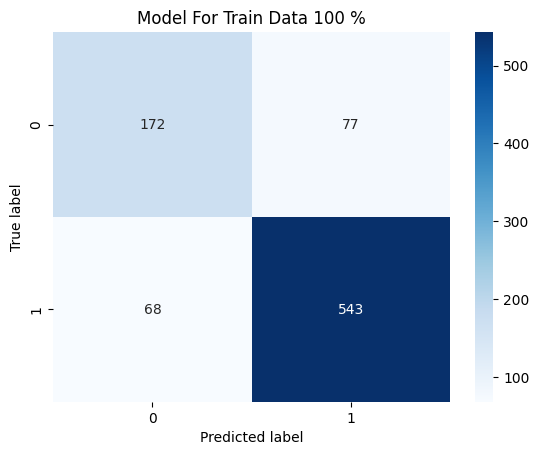

              precision    recall  f1-score   support

   Offensive       0.72      0.69      0.70       249
Notoffensive       0.88      0.89      0.88       611

    accuracy                           0.83       860
   macro avg       0.80      0.79      0.79       860
weighted avg       0.83      0.83      0.83       860

The Accuracy Score
0.8313953488372093



In [ ]:
report_2_100=test_method2(test_file,model_dir2_100,'output_test.csv',bert_tokenizer)

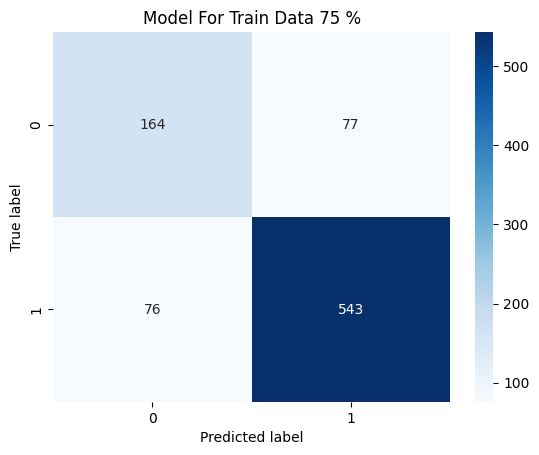

              precision    recall  f1-score   support

   Offensive       0.68      0.68      0.68       241
Notoffensive       0.88      0.88      0.88       619

    accuracy                           0.82       860
   macro avg       0.78      0.78      0.78       860
weighted avg       0.82      0.82      0.82       860

The Accuracy Score
0.8220930232558139



In [ ]:
report_2_75=test_method2(test_file,model_dir2_75,'output_test.csv',bert_tokenizer)

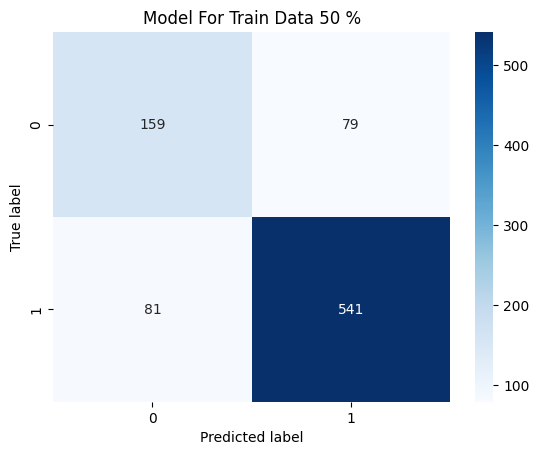

              precision    recall  f1-score   support

   Offensive       0.66      0.67      0.67       238
Notoffensive       0.87      0.87      0.87       622

    accuracy                           0.81       860
   macro avg       0.77      0.77      0.77       860
weighted avg       0.81      0.81      0.81       860

The Accuracy Score
0.813953488372093



In [ ]:
report_2_50=test_method2(test_file,model_dir2_50,'output_test.csv',bert_tokenizer)

Bert Classifier performance also slightly decline by lower the train data size

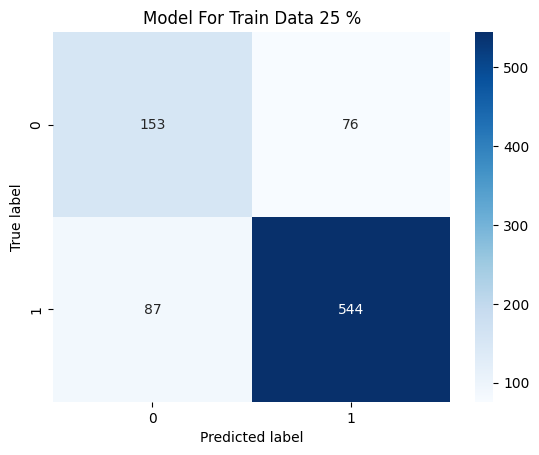

              precision    recall  f1-score   support

   Offensive       0.64      0.67      0.65       229
Notoffensive       0.88      0.86      0.87       631

    accuracy                           0.81       860
   macro avg       0.76      0.77      0.76       860
weighted avg       0.81      0.81      0.81       860

The Accuracy Score
0.8104651162790698



In [ ]:
report_2_25=test_method2(test_file,model_dir2_25,'output_test.csv',bert_tokenizer)

Now We will accumulate the F1 score of both model measured on different data size and then plot to see the affect train size on test data prediction.

In [ ]:
model_2_reports=[report_2_100,
report_2_75,
report_2_50,
report_2_25
]
model_1_reports=[report_1_100,
report_1_75,
report_1_50,
report_1_25]

model_1_f1=[x['accuracy'] for x in model_1_reports]
model_2_f1=[x['accuracy'] for x in model_2_reports]

x_val=[100,75,50,25]

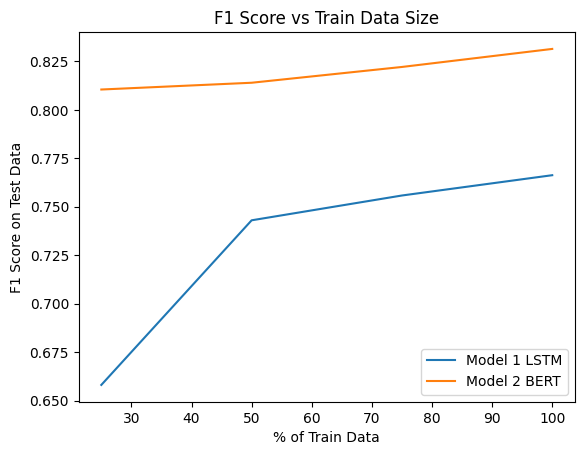

In [ ]:

plt.plot(x_val, model_1_f1, label='Model 1 LSTM')
plt.plot(x_val, model_2_f1, label='Model 2 BERT')
plt.xlabel('% of Train Data')
plt.ylabel('F1 Score on Test Data')
plt.title('F1 Score vs Train Data Size')

plt.legend()

plt.show()

It can clearly be observed that train data size affect the model's performance.